## Applications of ECOSTRESS: Drought and Wildfire Risk Assessment
### Rocky Mountain National Park, Colorado

Add introduction here.

Wildfire impacts to communities are on the rise. Changing hazard and risk for communities has been a function of warmer and drier climate (REF), lack of fire and a culture of fire suppression in fire-prone regions (REF), and rapid development in flammable landscapes (REF). Wildfire risk to communities is often transmitted from wildlands into the built environment or the Wildland Urban Interface (WUI), where buildings and people intermix with flammable vegetation. The Colorado Front Range is particularly vulnerable/susceptible to wildfire risk with a rapidly growing population and impacts from changing climatic patterns. 

(add more info here about the Park and East Troublesome Fire) - Rocky Mountain National Park (RMNP) ... Estes Park, CO and Grand Lake, CO, vulnerable populations fire risk transmitted from the park

Previous research has shown relationships between the intensity of a wildfire and the water stress in plants measured in the months before wildfire: https://ecostress.jpl.nasa.gov/news/111cnasa-data-on-plant-2018sweating-could-help-predict-wildfire-severity

(OPTION) Social Vulnerability Index (SVI) - how is fire risk distributed in relation to vulnerable populations? https://www.atsdr.cdc.gov/placeandhealth/svi/index.html

![East Troublesome](https://github.com/CU-ESIIL/HYR-SENSE/blob/main/images/east_troublesome-coloradoan.png)
Image source: https://www.coloradoan.com/story/news/2020/12/10/rocky-mountain-national-park-trails-reopening-after-fires-closed-area/3884310001/

Citations:

1.
2.
3. 

## Search and download ECOSTRESS Land Surface Temp. (LST) and Evapotranspiration (ET)

In this notebook, we will use the 'earthaccess' Python package to search and download ECOSTRESS data products which overlap RMNP (refer to this notebook for the introduction to earthaccess: XXX). Using this package, we can search for ECOSTRESS granules using our region of interest and identify data granules which meet certain criteria for analysis (i.e., cloud cover, seasonality, etc).

### Step 1. Setup the Notebook

First, we need to import our Python packages and define some environment variable like coordinate reference systems and file paths. 

In [1]:
"""
Load the necessary packages and set environment variables
"""

# Import packages
import os, shutil
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import rasterio as rio
import math

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
datadir = '/data-store/iplant/home/shared/esiil/HYR_SENSE/'

# File path information
print("Success")

Success


#### Define Custom Functions

These helper functions will be used throughout the notebook. For each function, there is a description of what purpose it serves and where it is used in the notebook. Feel free to read through each function to get an idea of what it does, but we will not cover these in great detail. Ask a facilitator if you have any questions!

In [18]:
def get_shapely_object(result:earthaccess.results.DataGranule):
    """
    Retrieve geospatial information from ECOSTRESS granule footprints.
    This function allows us to retrieve the geographic coverage for each granule and plot it on a map.
    
    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                       bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)


def get_png(result:earthaccess.results.DataGranule):
    """
    Retrieve the browse image from the search results
    This browse image can be used to display the granule quickly and effectively before downloading

    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    Leaflet interactive maps require a specific format for coordinates, this function sets that up for a given bounding box.

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


def extract_granule_id(link):
    return os.path.basename(link)[:-3]
    
print("Functions are ready to use!")

Functions are ready to use!


### Step 2. Data Preparation

#### Accessing data from the CyVerse Data Store

The CyVerse "data store" contains some geospatial and tabular data for the workshop. These data can be accessed directly using file paths. However, this sometimes can cause delays. To avoid these issues, we can copy the data for this notebook into a local directory, which will increase the analysis speed.

In [3]:
"""
Copy the data-store to 'local' directory
This enables quick access to data files
"""

# Identify the location of the HYR-SENSE "data store"
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/Drought-FireRisk'
# Set a destination path (this is a 'local' and temporary path)
dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/' # in the GitHub repo we cloned
if not os.path.exists(dest):
    os.mkdir(dest) # create the directory for the copied data, if needed
    
# Using 'shutil' package, copy all the files over
shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

'/home/jovyan/HYR-SENSE/data/Drought-FireRisk/'

#### Importing project data

Now that we have a local copy of our project data, we can read in some of the data files like our region of interest (ROI). For this notebook, we will load two spatial datasets:

- Rocky Mountain National Park (RMNP) boundary
- Colorado Fire Protection Districts (FPDs)

To begin, let's create a map of our ROI and the intersecting FPDs.

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/hyr-sense/share/proj failed


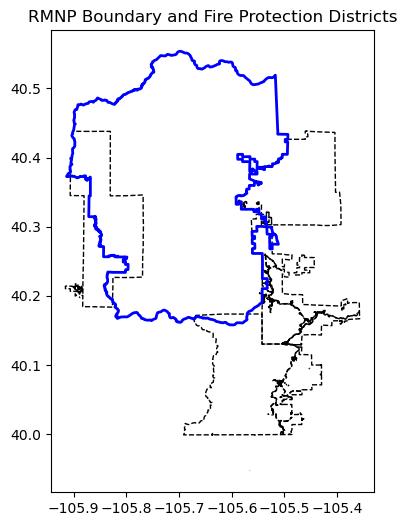

In [4]:
# Load the RMNP boundary as a GeoJSON using the Python package GeoPandas
rmnp = gpd.read_file(os.path.join(dest, 'NPS_ROMO_Boundary.geojson'))
rmnp = rmnp.to_crs(prj) # projected CRS

# Load the Colorado Fire Protection Districts
# Intersect with the RMNP boundary
fpd = gpd.read_file(os.path.join(dest, 'CO_Fire_Protection_Districts.geojson'))
fpd = fpd.to_crs(prj) # make sure the projections match
fpd_rmnp = fpd[fpd.intersects(rmnp.unary_union)] # Perform the spatial intersection

# Create a map of RMNP and adjacent FPDs
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# Plot the intersecting Fire Protection Districts
# (convert to geographic coordinates so axis labels are in lat/long)
fpd_rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='--', label='Intersecting Districts')
# Plot the RMNP boundary 
rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='blue', linewidth=2, label='RMNP Boundary')
# Add legend and title
plt.title('RMNP Boundary and Fire Protection Districts')
plt.show()

### Step 3. Search for ECOSTRESS Data Products 
 - Land Surface Temperature and Emissivity Daily L2 Global 70 m
 - Evapotranspiration (ET) PT-JPL Daily Daily L3 Global 70 m
 - Evaporative Stress Index (ESI) PT-JPL Daily L4 Gloabl 70 m 

Now that we have our ROI loaded, we can use the "earthaccess" Python package to find ECOSTRESS data products. In particular, we will search for the Land Surface Temperature and Emissivity Daily Gridded L2 70-m product (ECO_L2G_LSTE), Evapotranspiration Daily L3 70-m product (ECO3ETPTJPL), and the Evaporative Stress Index Daily L4 70 m product (ECO4ESIPTJPL). With earthaccess, we can search for and print all of the available data sets. Using this capability, we can also search for a specific data product by its "short name". To start, let's get a list of all the ECOSTRESS products available.

Read more about the data products:\
ECOSTRESS LSTE: https://lpdaac.usgs.gov/products/eco2lstev001/ \
ECOSTRESS ET: https://lpdaac.usgs.gov/products/eco3etptjplv001/ \
ECOSTRESS ESI: https://lpdaac.usgs.gov/products/eco4esiptjplv001/


In [5]:
## Query the collections for ECOSTRESS
Query = earthaccess.collection_query().keyword('ECOSTRESS')
print(f'Collections found: {Query.hits()}')

# Return search results as a list
collections = Query.fields(['ShortName']).get(Query.hits())

# Retrieve Collection short-names
print("All available data products: ")
[product['short-name'] for product in [collection.summary() for collection in collections]]

Collections found: 37
All available data products: 


['ECO2LSTE',
 'ECO4ESIPTJPL',
 'ECO4WUE',
 'ECO3ETPTJPL',
 'ECO2CLD',
 'ECO1BMAPRAD',
 'ECO1BRAD',
 'ECO3ETALEXI',
 'ECO4ESIALEXI',
 'ECO1BGEO',
 'ECO4ESIALEXIU',
 'ECO_L4G_ESI',
 'ECO_L4G_WUE',
 'ECO_L4T_ESI',
 'ECO_L4T_WUE',
 'ECO3ANCQA',
 'ECO3ETALEXIU',
 'ECO_L3G_JET',
 'ECO_L3G_MET',
 'ECO_L3G_SEB',
 'ECO_L3G_SM',
 'ECO_L3T_JET',
 'ECO_L3T_MET',
 'ECO_L3T_SEB',
 'ECO_L3T_SM',
 'ECO_L2G_CLOUD',
 'ECO_L2G_LSTE',
 'ECO_L2T_LSTE',
 'ECO_L2T_STARS',
 'ECO_L2_CLOUD',
 'ECO_L2_LSTE',
 'ECO1BATT',
 'ECO_L1B_ATT',
 'ECO_L1B_GEO',
 'ECO_L1B_RAD',
 'ECO_L1CG_RAD',
 'ECO_L1CT_RAD']

In [ ]:
# # (OPTIONAL) 
# # If you are using a Shapefile or GeoPackage you need to retrieve the coordinate pairs

# # ~ Extract a list coordinate pairs for ROI ~

# # First, reproject to WGS84 for coordinates are in degrees
# roi = roi.to_crs(epsg=4326)

# # Extract the bounds
# coord_list = []
# for iter, row in roi.iterrows():
#     bounds = row['geometry'].bounds
#     coord_list.append(bounds)
# print(coord_list)
# if len(coord_list) == 1:
#     coord_list = coord_list[0]
# else:
#     coord_list = coord_list

#### Define a search request using 'earthaccess'

We are ready to submit a search request for our ECOSTRESS data over RMNP. For this exercise, we will look for data within three seasonal time periods; spring (May), summer (July) and fall (September). In doing so, we can examine the changing drought and fire risk conditions over a single fire season for this region. 

In the code below, we define the three data products using their short names, the date ranges of interest, and a label for the season of the date range. Then, we loop through each data product short name and create a search request with our criteria

In [22]:
# 1. Define some search parameters
short_names = ['ECO_L2G_LSTE', 'ECO3ETPTJPL', 'ECO4ESIPTJPL']
date_ranges = [('2022-05-01','2022-05-31'),('2022-07-01','2022-07-31'),('2022-09-01','2022-09-30')]
seasons = ['Spring','Summer','Fall']  

# 2. Retrieve the coordinate pairs for the region of interest
rmnp = rmnp.to_crs(geog) # convert back to geographic coordinates
geom = rmnp.unary_union.envelope # dissolve into a single shape and get the envelope
coords = list(geom.exterior.coords) # retrieve the coordinate pairs

# 3. Loop through each short name
results = {} # empty dictionary to store the search results for each product
for short_name in short_names:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Data product: {short_name}")
    i=0 # counter
    season_results = [] # to store the search results for each season
    # 4. Loop each season
    for date_range in date_ranges:
        season = seasons[i] # get the season name for labelling
        print(f"Season: {season}; Date range: {date_range}")
    
        # 4a. Search for ECOSTRESS products matching our short names
        result = earthaccess.search_data(
            short_name=short_name,
            polygon=coords,
            temporal=date_range,
            count=500, 
        )
    
        # 4b. Save the results as a data frame, append to dictionary
        df = pd.json_normalize(result)
        df['season'] = season

        # 4c. Create shapely polygons for result
        geometries = [get_shapely_object(result[index]) for index in df.index.to_list()]
        # Convert to GeoDataframe
        results_gdf = gpd.GeoDataFrame(df, geometry=geometries, crs="EPSG:4326")
        
        # 4d. Add browse imagery links (we will use this later)
        results_gdf['browse'] = [get_png(granule) for granule in result]

        # 4e. Retrieve the data links (used later for downloading)
        data_links = pd.DataFrame([granule.data_links()[0] for granule in result], columns=['data_link']) 
        # print([os.path.basename(link)[:-3] for link in data_links['data_link']])
        data_links['granule_id'] = data_links['data_link'].apply(extract_granule_id)  
        # Merge the data link
        results_gdf = pd.merge(results_gdf, data_links, left_on="meta.native-id", right_on="granule_id")
        # 4f. Append the results to the season results list
        season_results.append(results_gdf)
        
        i=i+1

    # 5. Merge the results for all seasons and add to the dictionary (using the short name as the key)
    season_results = pd.concat(season_results)
    
    results[short_name] = season_results

~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO_L2G_LSTE
Season: Spring; Date range: ('2022-05-01', '2022-05-31')
Granules found: 32
Season: Summer; Date range: ('2022-07-01', '2022-07-31')
Granules found: 33
Season: Fall; Date range: ('2022-09-01', '2022-09-30')
Granules found: 28
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO3ETPTJPL
Season: Spring; Date range: ('2022-05-01', '2022-05-31')
Granules found: 14
Season: Summer; Date range: ('2022-07-01', '2022-07-31')
Granules found: 10
Season: Fall; Date range: ('2022-09-01', '2022-09-30')
Granules found: 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO4ESIPTJPL
Season: Spring; Date range: ('2022-05-01', '2022-05-31')
Granules found: 14
Season: Summer; Date range: ('2022-07-01', '2022-07-31')
Granules found: 10
Season: Fall; Date range: ('2022-09-01', '2022-09-30')
Granules found: 8


#### Examine the metadata from the search results  
It looks like we have some options for data products during this spatial and temporal window. However, to identify data granules which will be useful for analysis, we need to dig into the metadata a bit more. Thankfully, the earthaccess enables us to work with the metadata from our search results as a data frame. 

In [23]:
# Let's take a look at the columns available in the metadata
# We can use just one of the products to get an idea of the data structure
results_gdf = results['ECO_L2G_LSTE']
print(results_gdf.columns)

# How many granules do we have in total (all seasons)
print(f'{results_gdf.shape[0]} granules total')

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEVersion',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'season', 'geom

#### Identify granules with less than 5% cloud cover

We can use the metadata information to limit our search results to only granules with low cloud cover. This should help us narrow down the amount of data.

In [ ]:
for short_name in short_names:
    # Retrieve the search results data frame for that product
    gdf = results[short_name]
    
    # Find cloud-free granules
    print("Cloud cover statistics for granules: \n")
    print(gdf['umm.CloudCover'].describe())
    print("~~~~~~~~~~~~~~")
    
    # # How many granules have less than 5% cloud cover?
    # no_clouds_n = (search_df['umm.CloudCover'] <= 5).sum()
    # print(f"Number of granules with less than or equal to 5% cloud cover: {no_clouds_n}")
    # print("~~~~~~~~~~~~~~")
    
    # # Filter our search results to just these low cloud granules
    # search_df_nc = search_df[search_df['umm.CloudCover'] <= 5]
    # print(search_df_nc.head())

In [ ]:
#### # Create a list of columns to keep
# keep_cols = ['season','meta.concept-id','meta.native-id', 
#              'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
#              'umm.TemporalExtent.RangeDateTime.EndingDateTime',
#              'umm.CloudCover','umm.DataGranule.DayNightFlag', 'umm.GranuleUR',
#              'geometry','browse', 'shortname', 'data_link']
# # Remove unneeded columns
# results_gdf = results_gdf.loc[:, results_gdf.columns.intersection(keep_cols)]

results_gdf.rename(
    columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
               'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
               'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
               'umm.CloudCover':'cloud_cover',
               'umm.GranuleUR':'granule_id',
               'umm.DataGranule.DayNightFlag':'day_night',
              }, inplace=True)
results_gdf['datetime_obj'] = pd.to_datetime(results_gdf['start_datetime']) # 2i2c
results_gdf.head()

In [ ]:
# Spatial filtering

# Function to check if a bounding box fully contains the romo region
def bbox_contains(bbox_geom, roi_geom):
    return bbox_geom.contains(roi_geom.unary_union)

# Filter results based on spatial containment
filtered_results = results_gdf[results_gdf['geometry'].apply(lambda x: bbox_contains(x, romo.geometry))]

In [ ]:
# Create Figure and Select Background Tiles

fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot Region of Interest
romo.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

filtered_results.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

Now we can filter the granules to find ones which fully overlap the RMNP boundary.

In [ ]:
# Spatial filtering
filtered_asset_links = []
print(results_gdf['data_link'])
# Pick Desired Assets (leave _ on RFL to distinguish from RFLUNC, LST. to distinguish from LST_err)
desired_assets = ['LST.'] # Add more or do individually for reflectance, reflectance uncertainty, or mask
# Step through each sublist (granule) and filter based on desired assets.
for n, granule in enumerate(results_gdf['data_link']):
    for url in granule: 
        asset_name = url.split('/')[-1]
        if any(asset in asset_name for asset in desired_assets):
            filtered_asset_links.append(url)
filtered_asset_links

### Analyzing the ECOSTRESS data in the cloud

We now have a list of ECOSTRESS granules for our study region. We can now leverage the capabilities for analyzing data in the cloud using the ECOSTRESS Cloud-optimized GeoTiff (COG) formats. ... more info here ...

For example, we can create a median LSTE composite for RMNP for Spring and Fall.

In [ ]:
print(results_gdf['season'].unique())

In [ ]:
print(results_gdf['data_link'][0])

cog_urls = results_gdf['data_link'][0]

# Stream and process the data
for cog_url in cog_urls:
    with rio.open(cog_url) as src:
        # Read the entire COG
        array = src.read(1)  # Reading the first band

        # Process the array (e.g., calculate statistics or apply filters)
        mean_temp = np.mean(array)
        print(f"Mean temperature for granule: {mean_temp}")

        # Optionally, visualize the data
        plt.imshow(array, cmap='hot')
        plt.colorbar()
        plt.title("ECOSTRESS Land Surface Temperature")
        plt.show()